# The SDCA Algorithme

The SDCA algorithme is the stochastic version of the DCA (Dual Coordinate Acent) algorithm which solves a dual problem of (1). Specifically, for each i let $\phi^{*}_{i}$ : R → R be the convex conjugate of $\phi_{i}$ , namely, $\phi^{*}_{i}(u)$ = $max_{z}(zu−\phi_{i}(z))$. The dual problem is :

$\begin{array} 
\displaystyle \max_{\alpha \in \mathbb{R}^{n}} D(\alpha) & where & D(\alpha)=[\frac{1}{n} \sum_{i=1}^{n}-\phi^{*}_{i}(\alpha_{i}) - \frac{\lambda}{2}||\frac{1}{\lambda n} \sum_{i=1}^{n} \alpha_{i} x_{i}||^{2}]&  &  & (2) \\
\end{array}$

$\begin{array} 
\displaystyle \min_{w \in \mathbb{R}^{p}} P(w) & where & P(w)=[\frac{1}{n} \sum_{i=1}^{n} \phi^{*}_{i}(w^{T}x_{i}) + \frac{\lambda}{2}||w||^{2}]&  &  &  &  &  & (1) \\
\end{array}$

In our case, we will try to solve the SVM (support vector machine) optimization problem so the Eq (1) will take the hinge function as its loss function and a L2 regularizer. 

 the conjugate hinge loss is : $\phi^{*}_{i}(u)= \begin{cases} y_{i}u & if & -1 \le y_{i}u \le 0 \\ +\infty & & otherwise\end{cases}$

In [419]:
# Let's import the modules we will probably need.
import numpy as np
import numba as nb
import scipy.optimize as opt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Creating a Fake Dataset

In [420]:
# creating a fake dataset.
np.random.seed(0)

n_samples, n_features = 1000, 100
A = np.random.standard_normal((n_samples, n_features))
w = np.random.randn(n_features)
b = A.dot(w) + np.random.randn(n_samples)
y = np.sign(b)

In [418]:
def SDCA_hinge_L2(A, y, T=10000, T0=5000, lam=1., p = 10):
    
    # .. initialize variables ..
    n_samples, n_features = A.shape
    alpha = np.zeros(n_samples)
    w = 1 / (n_samples * lam) * (A.T.dot(alpha))  
    alpha_avr = np.zeros(n_samples)
    w_avr = np.zeros(n_features)
    
    # track the obj_func
    dual_objfun_history = []
    prim_objfun_history = []

    for i in range(T):
        # Pick an i from the sample
        idx = np.random.randint(0, n_samples)
        
        # the function to minimize
        def opti_prob_hinge(d):
            if(y[idx] == 1.):
                return -d - alpha[idx] + (lam * n_samples / 2) * np.linalg.norm(w + (1/(n_samples * lam)) * d * A[idx])
            return d + alpha[idx] + (lam * n_samples / 2) * np.linalg.norm(w + (1/(n_samples * lam)) * d * A[idx])
 
        # Optimization
        if(y[idx] == 1):
            delta_alpha = opt.minimize_scalar(opti_prob_hinge, bounds=(-alpha[idx],1-alpha[idx]), method='bounded').x
        else:
            delta_alpha = opt.minimize_scalar(opti_prob_hinge, bounds=(-1-alpha[idx],-alpha[idx]), method='bounded').x
        
        # updating the parameters
        w = w + 1 / (n_samples*lam) * delta_alpha * A[idx]
        alpha = alpha + delta_alpha * np.eye(n_samples)[idx]
        
        # dual and primal objective functions that we try to minimize (Eq 2) and (Eq 1)
        def dual_objfunc(alpha):
            return 1/n_samples * np.sum(-y * alpha) + lam/2 * np.linalg.norm(1/(lam * n_samples) * A.T.dot(alpha))
        
        def prim_objfunc(w):
            return 1/n_samples * np.sum(np.fmax(np.zeros(n_samples), np.ones(n_samples) - y * A.dot(w))) + lam/2 * np.linalg.norm(w)
        
        # tracking the objective function, p is used for the other datasets 
        if (i % (n_samples//p) ==0):
            dual_objfun_histo
            ry.append(dual_objfunc(alpha))
            prim_objfun_history.append(prim_objfunc(w))

        if(i > (T0-1)):
            alpha_avr += (1/(T-T0)) * alpha
            w_avr += (1/(T-T0)) * w
    
    
    return w_avr, alpha_avr, dual_objfun_history, prim_objfun_history

In [421]:
prim_sol, dual_sol, dual_costfunc, prim_costfunc = SDCA_hinge_L2(A, y)

In [422]:
%timeit SDCA_hinge_L2(A, y)

1 loop, best of 3: 11.8 s per loop


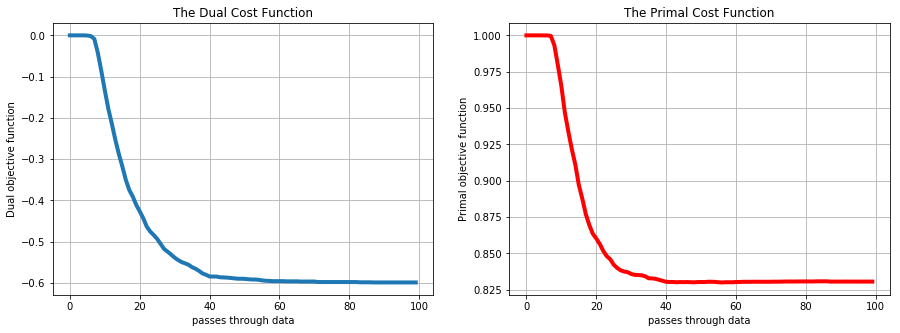

In [423]:
plt.figure(figsize=(15, 5))

# let's look at the dual cost function
plt.subplot(121)
plt.plot(dual_costfunc, lw=4)
plt.ylabel('Dual objective function')
plt.xlabel('passes through data')
plt.grid()
plt.title('The Dual Cost Function')

# let's look at the primal cost function
plt.subplot(122)
plt.plot(prim_costfunc,'r-', lw=4)
plt.ylabel('Primal objective function')
plt.xlabel('passes through data')
plt.grid()
plt.title('The Primal Cost Function')


plt.show()

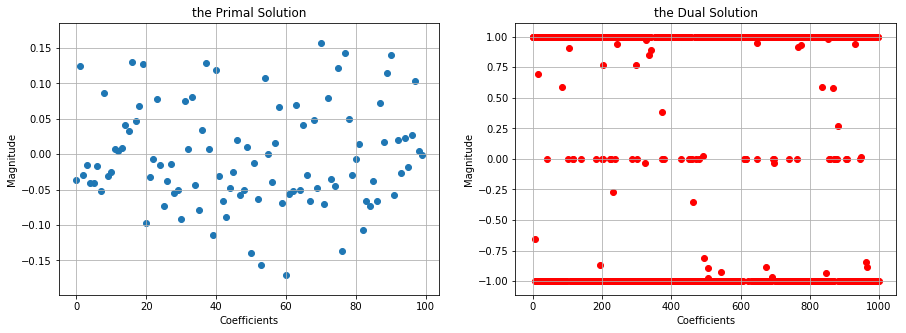

In [424]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
# let's also look at the coefficients of the Primal Solution
plt.scatter(np.arange(len(prim_sol)),prim_sol)
plt.ylabel('Magnitude')
plt.xlabel('Coefficients')
plt.grid()
plt.title('the Primal Solution')
# let's also look at the coefficients of the dual Solution
plt.subplot(122)
plt.scatter(np.arange(len(dual_sol)),dual_sol, color='red')
plt.ylabel('Magnitude')
plt.xlabel('Coefficients')
plt.grid()
plt.title('the Dual Solution')
plt.show()

### Loading Data

 We are going to load two Datasets : S&P 500 time series (GSPC) and the Voice Kaggle Dataset. I manipulated the datasets in ordre to be ready to use in the algorithms. I just created some features for the two datasets and I changed the number of modalities of the output variable for the GSPC dataset which becomes ('No action':1,'Action':-1). The output variable of the Voice Dataset is ("Male":1,"Female":-1).

#### Let's see some characteristics of the two datasets

| Dataset | training size  | test size  | number of features  |
|:-:|:-:|:-:|:-:|---|
| Sexe  | 2534  |  634 | 20  |   
| GSPC  |  7977 | 1995  | 27  |

In [436]:
# Loading the GSPC dataset
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

bd1 = np.genfromtxt("/home/ismail/Documents/ENSAE/3eme_annee/data_science/DSOML/data/gspc.csv", delimiter=',',skip_header=True ,dtype=float)

train_bd1, test_bd1 = train_test_split(bd1, test_size= 0.2)


trb1  = train_bd1[:,28:29].copy()
trA1  = train_bd1[:,1:28].copy()

teb1  = test_bd1[:,28:29].copy()
teA1  = test_bd1[:,1:28].copy()

# Normalization of the training dataset
tr_A1 = preprocessing.normalize(trA1, norm='l2')
te_A1 = preprocessing.normalize(teA1, norm='l2')

In [437]:
# Loading the Voice Kaggle Dataset (sexe revognition from voice)
bd2 = np.genfromtxt("/home/ismail/Documents/ENSAE/3eme_annee/data_science/DSOML/data/sexe_rec.csv", delimiter=',',skip_header=True ,dtype=float)

train_bd2, test_bd2 = train_test_split(bd2, test_size= 0.2)

trb2  = train_bd2[:,21:22].copy()
trA2  = train_bd2[:,1:21].copy()

teb2  = test_bd2[:,21:22].copy()
teA2  = test_bd2[:,1:21].copy()

# Normalization of the training dataset
tr_A2 = preprocessing.normalize(trA2, norm='l2')
te_A2 = preprocessing.normalize(teA2, norm='l2')

#### Application of the SDCA on the two Datasets.

In [457]:
prim_sol1, dual_sol1, dual_costfunc1, prim_costfunc1 = SDCA_hinge_L2(tr_A1, trb1, T= 20000,T0=10000,p=1000)

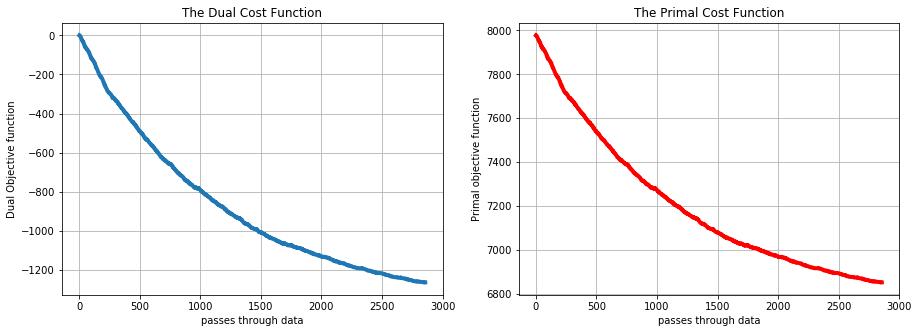

In [458]:
plt.figure(figsize=(15, 5))

# let's look at the dual cost function
plt.subplot(121)
plt.plot(dual_costfunc1, lw=4)
plt.ylabel('Dual Objective function')
plt.xlabel('passes through data')
plt.grid()
plt.title('The Dual Cost Function')

# let's look at the primal cost function
plt.subplot(122)
plt.plot(prim_costfunc1,'r-', lw=4)
plt.ylabel('Primal objective function')
plt.xlabel('passes through data')
plt.grid()
plt.title('The Primal Cost Function')


plt.show()

In [455]:
prim_sol2, dual_sol2, dual_costfunc2, prim_costfunc2 = SDCA_hinge_L2(tr_A2, trb2,T= 20000,T0=10000, p=1000)

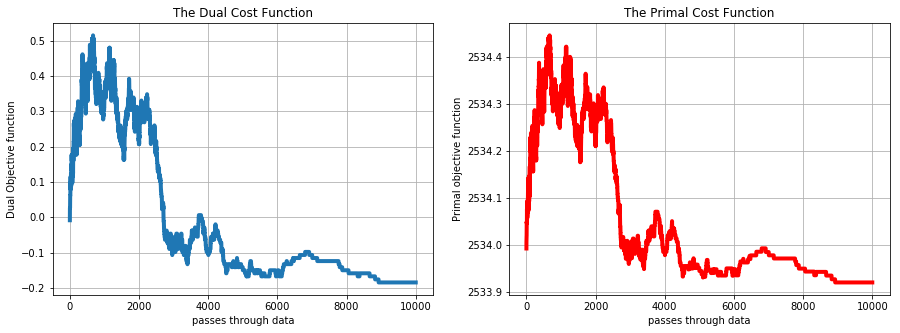

In [456]:
plt.figure(figsize=(15, 5))

# let's look at the dual cost function
plt.subplot(121)
plt.plot(dual_costfunc2, lw=4)
plt.ylabel('Dual Objective function')
plt.xlabel('passes through data')
plt.grid()
plt.title('The Dual Cost Function')

# let's look at the primal cost function
plt.subplot(122)
plt.plot(prim_costfunc2,'r-', lw=4)
plt.ylabel('Primal objective function')
plt.xlabel('passes through data')
plt.grid()
plt.title('The Primal Cost Function')


plt.show()

### Pegasos Algorithm

We will use the Pegasos algorithm in order to compare it with the SDCA algorithm. Pegasos performs stochastic subgradient descent on the primal objective Eq.(1) with a carefully chosen stepsize ($\frac{1}{\lambda t}$). In our case, we will implement the mini-batch version of the Pegasos algorithm explained as follow :
 
On each iteration Pegasos operates as follow. Initially, we set $w_1$ to the zero vector. On
iteration t of the algorithm, we choose set of examples $A_{t} \in S$, $(S= \{(x_{i}, y_{i})\}^{n}_{i=1})$ with   $|A_t|=k$ and $1<k<m$. We then replace the objective in Eq. (1) : 
$$
\begin{array} 
\\f( w; A_t) = \frac{\lambda}{2} \|w \|_2 + \frac{1}{k}  \sum_{i \in A_t} l_{hinge}(w;(x_i,y_i)) & & & & & (3) \\
\end{array}
$$ 

we calculate the subgradient : $$\nabla_t = \lambda w_t - \frac{1}{k} \sum_{i \in A_t} \mathbb{1}(y_i  w_t^{T} x_i < 1)  $$

then, we update $w_{t+1} \leftarrow w_t - η_t \nabla_t $ using the stepsize $η_t = \frac{1}{\lambda t }$ .


In [460]:
def pegasos_hinge_L2(A, y,k, max_iter = 100 ,lam=1.):
    # .. initialize variables ..
    n_samples, n_features = A.shape
    # a guess
    w = np.zeros(n_features)
    # track the obj_func
    obj_fun_history = []
    for i in range(max_iter):
        n_t =  1 / (lam * (i+1))
        index = np.random.randint(n_samples,size= k)
        somme = np.zeros(n_features)
        for j in index:
            if((A[j].T.dot(w)) * y[j] < 1):
                somme +=y[j] * A[j]
        
        w = (1-n_t*lam) * w + n_t/k * somme
        def obj_func(x):
            return lam/2 * np.linalg.norm(x) + 1/n_samples * sum(np.fmax(np.zeros(n_samples),np.ones(n_samples) - y * A .dot(x))) 
 
        # track the obj_func
        obj_fun_history.append(obj_func(w))
    
    return w, obj_fun_history

In [461]:
%timeit sol, cost_func_pegasos = pegasos_hinge_L2(A, y, 30)

100 loops, best of 3: 14.5 ms per loop


### Comparison between Pegasos and SDCA algorithme using a fake dataset

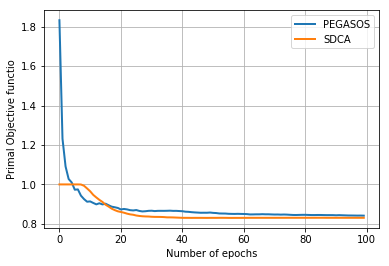

In [462]:
# let's look to the cost function
plt.plot(cost_func_pegasos, lw=2, label='PEGASOS')
plt.plot(prim_costfunc, lw=2, label='SDCA')
plt.grid()
plt.legend()
plt.ylabel('Primal Objective functio')
plt.xlabel('Number of epochs')
plt.show()

#### Mini-Batch Pegasos solution  Vs  SCDA Primal Solution 

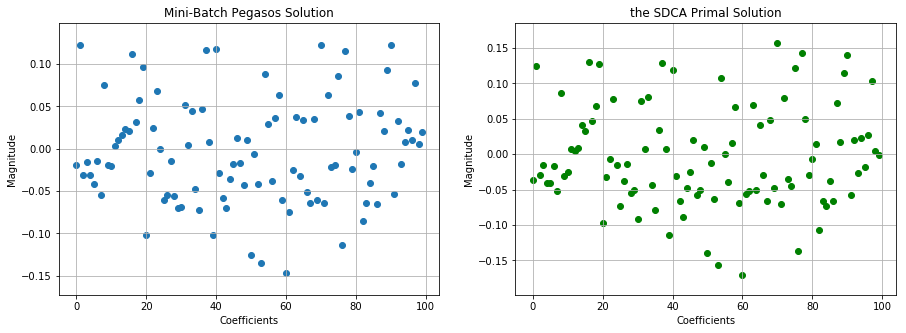

In [465]:
plt.figure(figsize=(15, 5))

# let's look at the Solution coefficients of the PEGASOS Algorithm
plt.subplot(121)
plt.scatter(np.arange(len(sol)), sol)
plt.ylabel('Magnitude')
plt.xlabel('Coefficients')
plt.grid()
plt.title("Mini-Batch Pegasos Solution")

# let's also look at the coefficients of the Primal Solution of the SDCA
plt.subplot(122)
plt.scatter(np.arange(len(prim_sol)),prim_sol, color='green')
plt.ylabel('Magnitude')
plt.xlabel('Coefficients')
plt.grid()
plt.title('the SDCA Primal Solution')

plt.show()